### Lissage exponenetiel 



Veille :

0) le lissage exponentiel

Le lissage exponentiel est une méthode de prévision de séries chronologiques pour les données univariées.

Les méthodes de séries chronologiques telles que la famille de méthodes Box-Jenkins ARIMA (méthodologie composée de quatre étapes : Analyse préliminaire, spécification, estimation et validation) développent un modèle dans lequel la prédiction est une somme linéaire pondérée d'observations ou de retards passés récents.

Les méthodes de prévision de lissage exponentiel sont similaires en ce qu'une prédiction est une somme pondérée d'observations passées, mais le modèle utilise explicitement un poids décroissant exponentiellement pour les observations passées.

Les méthodes de lissage exponentiel peuvent être considérées comme des pairs et une alternative à la populaire classe de méthodes Box-Jenkins ARIMA pour la prévision de séries chronologiques.

Collectivement, les méthodes sont parfois appelées modèles ETS, faisant référence à la modélisation explicite de l'erreur, de la tendance et de la saisonnalité.


1) Lissage exponentielle simple

Pourquoi ce nom ?

Pour des données univariées sans tendance ni saisonnalité


Formulation

Il nécessite un seul paramètre, appelé alpha (une), également appelé facteur de lissage ou coefficient de lissage.
Ce paramètre contrôle la vitesse à laquelle l'influence des observations à des pas de temps antérieurs décroît de manière exponentielle. 


![LES](Data/les.png)

Soit,
![LES](Data/lesbis.png)

où et = yt-1 - ŷt-1

cf: http://www.jybaudot.fr/Previsions/les.html

Alpha est souvent défini sur une valeur comprise entre 0 et 1. Des valeurs élevées signifient que le modèle prête principalement attention aux observations passées les plus récentes, tandis que des valeurs plus petites signifient qu'une plus grande partie de l'historique est prise en compte lors de la prédiction.

2) Lissage exponentielle double 

Quelle propriete le modele attrape t il de plus ?

extension du lissage exponentiel qui ajoute explicitement la prise en charge des tendances dans les séries chronologiques univariées


Formulation

En plus de alpha paramètre de contrôle du facteur de lissage du niveau, un facteur de lissage supplémentaire est ajouté pour contrôler la décroissance de l'influence du changement de tendance appelée bêta (b).

Pour les prévisions à plus long terme (à étapes multiples), la tendance peut se poursuivre de manière irréaliste. En tant que tel, il peut être utile d'atténuer la tendance au fil du temps.


[LED/Hot](https://slideplayer.fr/slide/1829975/9/images/14/3.+Lissage+de+Holt+Tout+comme+le+LED%2C+le+lissage+de+Holt+permet+d%E2%80%99%C3%A9tablir+une+fonction+de+pr%C3%A9vision+lin%C3%A9aire..jpg)

L'amortissement signifie réduire la taille de la tendance au cours des étapes de temps futures jusqu'à une ligne droite (pas de tendance).

Comme pour la modélisation de la tendance elle-même, nous pouvons utiliser les mêmes principes pour amortir la tendance, en particulier de manière additive ou multiplicative pour un effet d'amortissement linéaire ou exponentiel. Un coefficient d'amortissement Phi (p) est utilisé pour contrôler le taux d'amortissement.


3) Lissage exponentiel triple / Méthode de Holt-Winters 


Quelle propriete le modele attrape t il de plus ?

Le lissage exponentiel triple est une extension du lissage exponentiel qui ajoute explicitement la prise en charge de la saisonnalité à la série chronologique univariée.

Formulation

En plus des facteurs de lissage alpha et bêta, un nouveau paramètre est ajouté appelé gamma (g) qui contrôle l'influence sur la composante saisonnière.

[LET/Holt_Winters](https://slideplayer.fr/slide/1829975/9/images/17/4.+Lissage+de+Winters+La+formule+est+la+suivante.jpg)

Pour garantir que la saisonnalité est correctement modélisée, le nombre de pas de temps dans une période saisonnière (Point final) doit être spécifié. Par exemple, si la série était des données mensuelles et que la période saisonnière était répétée chaque année, alors la période = 12.

In [6]:
import math                         
import numpy as np                  
import time
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns             
plt.rcParams["figure.figsize"]=(10, 6)

On considère le jeu de données airpekin, concernant la qualité de l'air

In [7]:
polution_ts=pd.read_csv('pollution.csv',index_col=0,parse_dates=True)[['pollution']]
polution_ts.head()

,pollution
year_month_day_hour,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0


Proposer une visualisation de la pollution pour l'ozone sur la période d'étude.

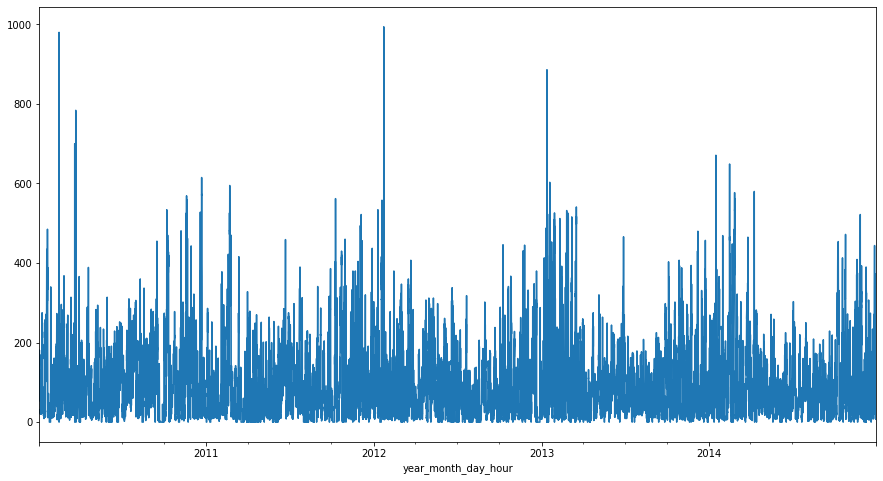

In [8]:
polution_ts['pollution'].plot(figsize=(15,8))

Donner une représentation par mois de la pollution. Quel est le mois le plus pollué ?

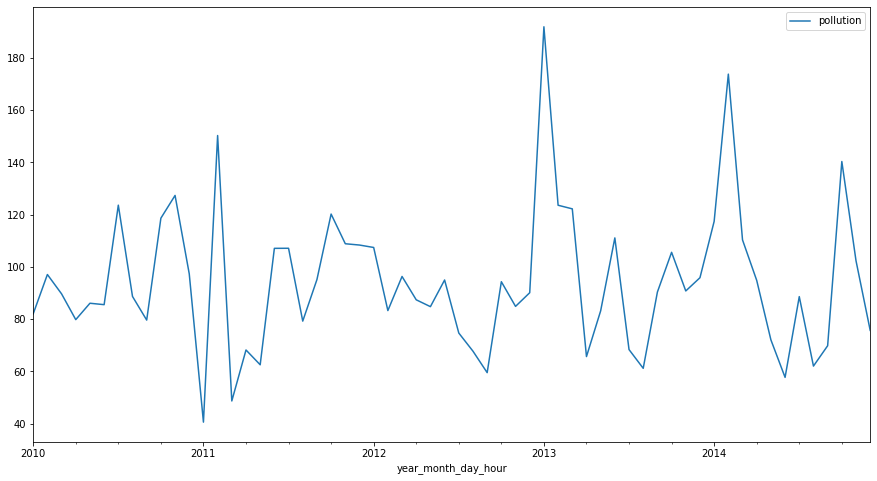

In [9]:
polution_ts.resample('M').mean().plot(figsize=(15,8))

### Etude de la série

#### Decomposition de la serie

En utilisant seasonal_decompose, decomposer votre serie temporelle sous plusieurs échantillonage:

- Par mois
- Par semaines

Un modèle de décomposition consiste à appliquer des transformations pour simplifier sa série temporelle. C’est une méthode très efficace et très générale, son application est omniprésente en analyse des séries temporelles, avec différentes variations.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


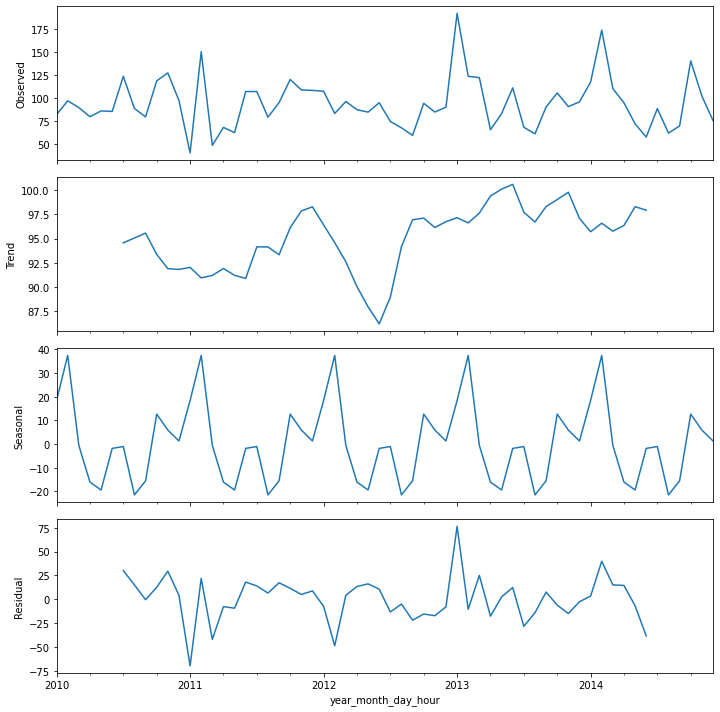

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(10, 10)

x=polution_ts["pollution"].resample('M').mean()

decomp_x = seasonal_decompose(x.fillna(method='ffill'),  model='additive')
decomp_x.plot()

plt.show()

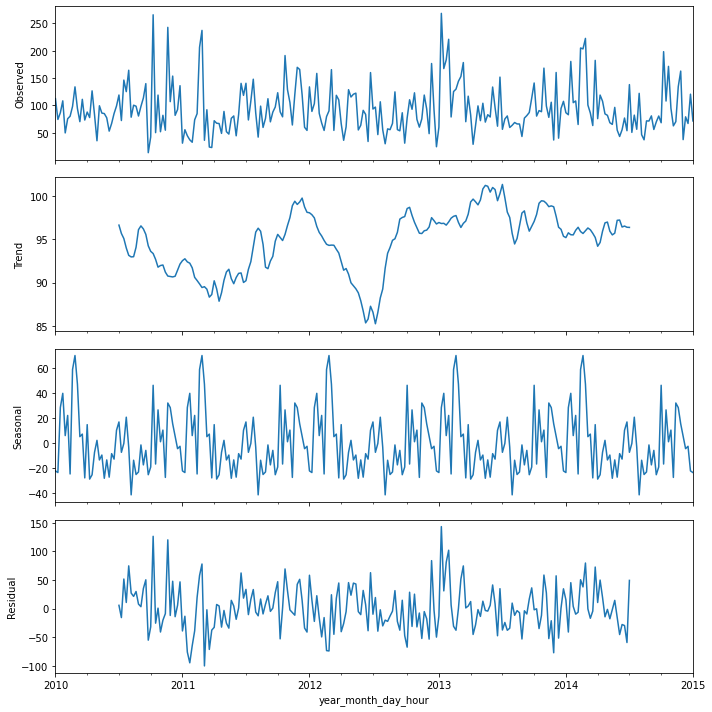

In [11]:
x=polution_ts["pollution"].resample('w').mean()

decomp_x = seasonal_decompose(x.fillna(method='ffill'),  model='additive')
decomp_x.plot()

plt.show()

#### Modele de lissage exponentiel Simple

- alpha imposé

nb :la valeur alpha est appelée smoothing_level

In [12]:
import statsmodels.api as sm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Je defini la serie à modeliser
x=polution_ts["pollution"].resample('w').mean().dropna()
# Je filtre pour conserver la premiere semaine de 2015 comme observation d'evaluation du model


# Creation de l'objet LES
mod=SimpleExpSmoothing(x[:-1])
# Calcul des parametres
results = mod.fit(smoothing_level=0.5)


print(results.summary().tables[0])
print(results.summary().tables[1])

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  261
Model:             SimpleExpSmoothing   SSE                         614073.899
Optimized:                       True   AIC                           2030.234
Trend:                           None   BIC                           2037.363
Seasonal:                        None   AICC                          2030.391
Seasonal Periods:                None   Date:                 Tue, 17 May 2022
Box-Cox:                        False   Time:                         09:57:00
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5000000                alpha                False
initial_level              96.614172                

Vous remarquerez la presentation des scores AIC et BIC nous donnant des informations sur la qualité predictive du modele créé

L'analyse du résidu

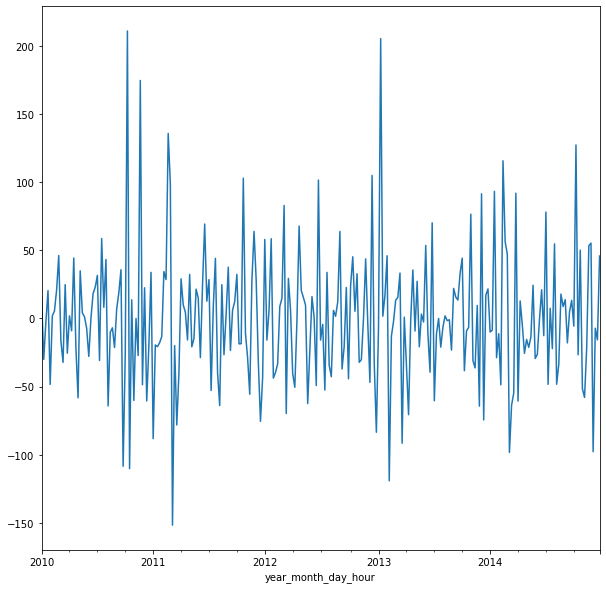

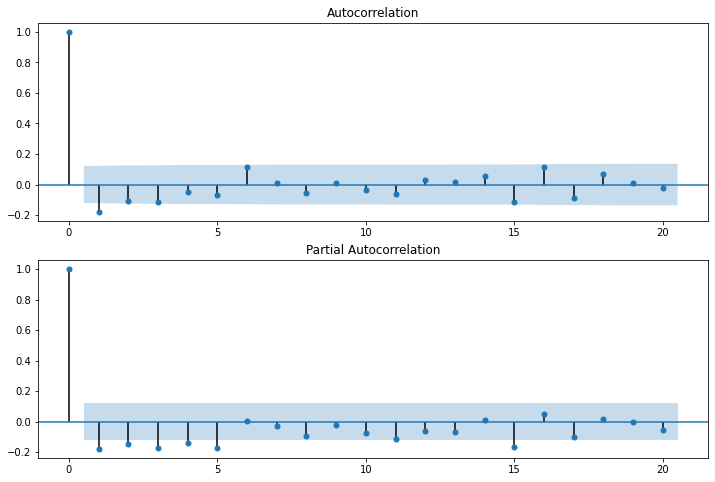

In [13]:
results.resid.plot()

plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=20, ax=ax2)
plt.show()

#### L'erreur de prediction sur la derniere valeur de la serie

In [17]:
pred = results.predict(start="2014-12-29",end="2015-01-04")
pred

KeyError: ignored

In [18]:
x['2014-12-29':]

year_month_day_hour
2015-01-04    71.708333
Freq: W-SUN, Name: pollution, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(x['2014-12-29':], pred, squared=False)
rms

####  Alpha ajusté automatiquement

In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

x=polution_ts["pollution"].resample('w').mean()
x=x.dropna()

mod=SimpleExpSmoothing(x[:-1])
results = mod.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])

pred = results.predict(start="2014-12",end="2015-1-4")

# OU

pred= results.forecast(1)

rms = mean_squared_error(x['2014-12-29':], pred['2014-12-29':], squared=False)
rms

#### Projeter la prediction jusqu'à la fin de l'année 2015

In [ ]:
pred = results.predict(start="2014-12",end="2016")
# OU
pred= results.forecast(10)

ax = x['2014':].plot(label='observed')
pred.plot( label='One-step ahead Forecast', alpha=.7)

#### Lissage exponentiel double (Holt)

cas particulier : lissage exponentiel double avec une tendance additive

- trend : Le type de composant de tendance, comme "add" Pour additif ou "mul»Pour multiplicatif. La modélisation de la tendance peut être désactivée en la définissant sur None.

- amortissement: Si le composant de tendance doit être amorti ou non, soit True ou False.




Les coefficients de lissage du modèle, par défaut, sont optimisés (par exemple optimized = True). Ces coefficients comprennent:

- smoothing_level (alpha): le coefficient de lissage du niveau.
- smoothing_trend (bêta): le coefficient de lissage de la tendance.

In [ ]:
results.forecast(10)

In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


x=polution_ts["pollution"].resample('w').mean().dropna()


mod=Holt(x[:-1],exponential=True,damped_trend=False)
results = mod.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])

pred = results.predict(start="2014-12",end="2015-1-4")

# OU

pred= results.forecast(1)

from sklearn.metrics import mean_squared_error

rms = mean_squared_error(x['2014-12-29':], pred['2014-12-29':], squared=False)
rms

#### Projeter la prediction jusqu'à la fin de l'année 2015

In [ ]:
pred = results.predict(start="2014-12",end="2016")

ax = x['2014':].plot(label='observed')
pred.plot( label='One-step ahead Forecast', alpha=.7)


#### lissage exponentiel double et triple (Hot Winters) 

- saisonnier: Le type de composante saisonnière, comme "add" Pour additif ou "mul»Pour multiplicatif. La modélisation du composant saisonnier peut être désactivée en le définissant sur None.





- Alpha: Facteur de lissage pour le niveau.
- Bêta: Facteur de lissage de la tendance.
- Gamma: Facteur de lissage de la saisonnalité. (smoothing_seasonal (gamma): le coefficient de lissage de la composante saisonnière.)
- Type de tendance: Additif ou multiplicatif.
- Type d'amortissement: Additif ou multiplicatif.
- Phi: Coefficient d'amortissement. (amortissement_slope (phi): le coefficient pour le controle du taux d'amortissement)
- Type de saisonnalité: Additif ou multiplicatif. ( seasonal: Le type de composante saisonnière, comme "add" Pour additif ou "mul»Pour multiplicatif. La modélisation du composant saisonnier peut être désactivée en le définissant sur None)
- season_periods: Pas de temps en période saisonnière (season_periods: Le nombre de pas de temps dans une période saisonnière, par exemple 12 pour 12 mois dans une structure saisonnière annuelle)

In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

x=polution_ts["pollution"].resample('w').mean().dropna()

mod=ExponentialSmoothing(x[:-1],
    trend="add",
    seasonal="add",
    seasonal_periods=52,
    use_boxcox=True,
    initialization_method="estimated")
results = mod.fit()



print(results.summary().tables[0])
print(results.summary().tables[1])

pred = results.predict(start="2014-12",end="2015-1-4")


from sklearn.metrics import mean_squared_error


ax = x['2014':].plot(label='observed')
pred.plot( label='One-step ahead Forecast', alpha=.7)



ax.set_xlabel('Date')
ax.set_ylabel('pollution')
plt.legend()

plt.show()

rms = mean_squared_error(x['2014-12-29':], pred['2014-12-29':], squared=False)
rms


#### Projeter la prediction jusqu'à la fin de l'année 2015

In [ ]:
pred = results.predict(start="2014-12",end="2016")

ax = x['2014':].plot(label='observed')
pred.plot( label='One-step ahead Forecast', alpha=.7)


### Prediction mensuelle

Reprenez la serie, puis echantilonnez par mois
